# MNIST subset with convolutional layers

8k training / 2k validation subsample of 60k images.

**colab** github can't seem to display notebooks so...

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/playdl/blob/master/notebooks/mnist-CNN.ipynb)

## Setup
Make sure to enable this to see progress bars:

```
$ jupyter nbextension enable --py widgetsnbextension
$ jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [2]:
!pip install -q --no-deps tensorflow-addons~=0.7
!pip install -q "tqdm>=4.36.1"

## MNIST Images

In [42]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
    accuracy_score, confusion_matrix
import tensorflow as tf
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [43]:
# put back together so we can take our own subset
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)
n, w, h = X.shape

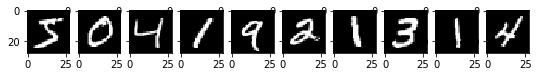

In [44]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,10,figsize=(9,3))
for i in range(10):
    axes[i].imshow(X[i], cmap='gray')
plt.show()

### Make sure to shuffle

Shuffle before getting subsample or else we get mostly 0s,1s,2s etc...

In [45]:
subset = 10_000
idx = np.random.randint(0,n,size=subset)
X = X[idx,:,:]
y = y[idx]

**Reshape to have a dimension for grey scale**

In [46]:
X = X.reshape(-1,w,h,1)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Using {len(X_train)} training images")

Using 8000 training images


## CNN with 1 conv layer and 1 dense layer

In [48]:
import tensorflow_addons as tfa
from keras.datasets import mnist
from tensorflow.keras import models, layers, callbacks, optimizers
import tqdm
from tqdm.keras import TqdmCallback

### Don't forget to normalize data for DL

In [49]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [109]:
num_classes = 10
layer1 = 32
layer2 = 32
batch_size = 32

model = models.Sequential()
model.add(layers.Conv2D(layer1, (3,3), input_shape=(w,h,1), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

#model.add(layers.Dense(layer2, activation='relu'))

model.add(layers.Dense(num_classes, activation='softmax'))

In [110]:
# learning_rate = 0.15
# opt = optimizers.Adam(lr=learning_rate)
opt = optimizers.RMSprop() # this one seems a bit better

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

# callback = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train,
                    shuffle=True,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

In [111]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
val_accur = accuracy_score(y_test, y_pred)
print("Keras validation accuracy", val_accur)

conf = confusion_matrix(y_test, y_pred)
print(conf)

Keras validation accuracy 0.975
[[188   0   0   0   0   2   2   0   1   0]
 [  0 238   0   0   1   0   1   1   1   0]
 [  0   3 193   1   0   1   0   1   1   0]
 [  0   0   1 179   0   0   0   2   0   1]
 [  0   1   0   0 164   0   0   0   1   2]
 [  0   0   1   0   0 176   0   1   0   2]
 [  0   0   0   0   1   1 206   0   2   0]
 [  0   0   1   0   0   1   0 212   0   2]
 [  0   0   0   2   2   1   1   1 200   1]
 [  0   0   0   0   1   2   0   2   1 194]]


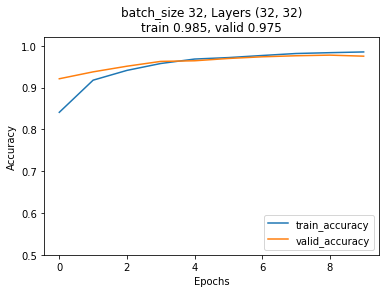

In [112]:
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

accur = history.history['accuracy']
plt.plot(accur, label='train_accuracy')
val_accur = history.history['val_accuracy']
plt.plot(val_accur, label='valid_accuracy')
plt.title(f"batch_size {batch_size}, Layers {layer1,layer2}\ntrain {accur[-1]:.3f}, valid {val_accur[-1]:.3f}")
#plt.xlim(0, 200)
plt.ylim(0.5, 1.02)
plt.legend(loc='lower right')
plt.show()

Wow. With just 1 conv layer with 32 filters and 1 following dense layer of 64, we get .98 test accuracy! Only 20 epochs.   Even with just 5 epochs, we get .978 accuracy. Takes about 10s.

Interesting. Going from batch size 64 to 100 drops accuracy to about .96, a significant drop, unless I increase the epochs to about 10 but that is still tiny.

Dropping batch size to 32 with 10 epochs, gives .98.  Looks like a flat line for both curves so even a few epochs work! wow.

Dropping 2nd layer from 64 to 32 doesn't really change accur. It's .979 at 10 epochs.

Tossing out the 2nd layer altogether only drops it to .976. So just 1 layer and it's convolutional. Bump batch size from 64 to 500 and same net drops to 0.924 accuracy.  Drop batch size to 32 and accur still good at .975.